# Sentiment Analysis (using LSTM, GRU)

In [1]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import contractions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# !pip install contractions
# nltk.download('stopwords')
# nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_CIVE/project/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


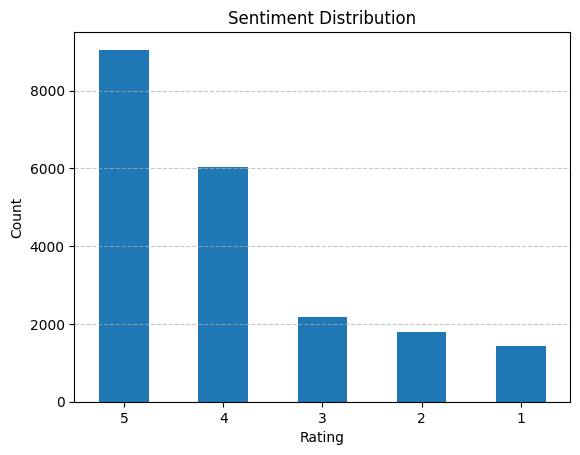

In [6]:
# Count the occurrences of each sentiment
sentiment_distribution = df['Rating'].value_counts()

# Plot the sentiment distribution
sentiment_distribution.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

In [8]:
# Check class distribution
df['Sentiment'].value_counts()

,count
Sentiment,
positive,15093
negative,3214
neutral,2184


In [9]:
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df['Sentiment']), y=df['Sentiment'])

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Efficient for lemmatization

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Expanding contractions
    text = contractions.fix(text)

    # Removing file paths and URLs
    text = re.sub(r'http\S+|www\S+|[a-zA-Z]:\\[^\s]*', '', text)

    # Removing HTML tags if any exist
    if "<" in text and ">" in text:  # Basic check for HTML tags
        text = BeautifulSoup(text, features="html.parser").get_text()

    # Removing punctuation and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Removing stop words and lemmatizing
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    # Handling negations
    text = " ".join(words).replace("n't", " not").replace("'re", " are").replace("'s", " is")

    # Removing extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applying preprocessing to all reviews
df['cleaned_review'] = df['Review'].apply(preprocess_text)


In [12]:
df

,Review,Rating,Sentiment,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,positive,best kept secret rd time staying charm star ca...
20487,great location price view hotel great quick pl...,4,positive,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,negative,ok look nice modern outside desk staff nt part...
20489,hotel theft ruined vacation hotel opened sept ...,1,negative,hotel theft ruined vacation hotel opened sept ...


### Train-test Split

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional

In [14]:
# Splitting the data into features and labels
X = df['cleaned_review']  # Input feature
y = df['Sentiment']       # Target labels

# Splitting the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display the sizes of each split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check the balance of sentiment labels in each set
print("\nTraining set sentiment distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation set sentiment distribution:")
print(y_val.value_counts(normalize=True))
print("\nTest set sentiment distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 16392
Validation set size: 2049
Test set size: 2050

Training set sentiment distribution:
Sentiment
positive    0.736579
negative    0.156845
neutral     0.106576
Name: proportion, dtype: float64

Validation set sentiment distribution:
Sentiment
positive    0.736457
negative    0.156662
neutral     0.106881
Name: proportion, dtype: float64

Test set sentiment distribution:
Sentiment
positive    0.736585
negative    0.157073
neutral     0.106341
Name: proportion, dtype: float64


In [15]:
X_train.shape, X_val.shape, X_test.shape

((16392,), (2049,), (2050,))

### Handling Class Imbalance

In [16]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(pd.DataFrame(X_train), y_train)
X_train_balanced = X_train_balanced.iloc[:, 0]  # Convert back to Series

In [17]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(pd.DataFrame(X_train), y_train)
X_train_balanced = X_train_balanced.iloc[:, 0] # Convert back to Series

In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 2.1252430960715674, 1: 3.1276473955352033, 2: 0.4525426536359119}


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 10000  # Maximum vocabulary size
oov_token = "<OOV>"  # Token for out-of-vocabulary words

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train_balanced)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_balanced)
X_valid_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max(len(seq) for seq in X_train_seq)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Display shapes of the padded datasets
print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_valid_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")


# Ensure y_train_balanced, y_val, and y_test are ready for model training
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels into numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)  # For balanced training data
y_valid_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Training labels shape: {y_train_encoded.shape}")
print(f"Validation labels shape: {y_valid_encoded.shape}")
print(f"Test labels shape: {y_test_encoded.shape}")

Training data shape: (5241, 1861)
Validation data shape: (2049, 1861)
Test data shape: (2050, 1861)
Training labels shape: (5241,)
Validation labels shape: (2049,)
Test labels shape: (2050,)


In [20]:
# Path to GloVe file (replace with your path)
glove_file_path = "/content/drive/MyDrive/Deep_Learning_CIVE/project/glove.6B.100d.txt"
embedding_dim = 100

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

# Create embedding matrix
word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index)) + 1  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)

Loaded 400001 word vectors from GloVe.
Embedding matrix shape: (10001, 100)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,            # GloVe embedding dimensions
    weights=[embedding_matrix],          # Pre-trained GloVe embeddings
    input_length=max_length,             # Max sequence length
    trainable=False                      # Embeddings are not trainable
))
lstm_model.add(LSTM(64, return_sequences=False))  # Single LSTM layer
lstm_model.add(Dropout(0.5))                      # Regularization
lstm_model.add(Dense(3, activation='softmax'))    # Multi-class classification (3 classes)

# Compile the model
lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for multi-class
    metrics=['accuracy']
)

# Train the model
lstm_history = lstm_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3339 - loss: 1.8864 - val_accuracy: 0.1069 - val_loss: 1.8047
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3374 - loss: 1.7372 - val_accuracy: 0.1069 - val_loss: 2.1612
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3333 - loss: 1.7246 - val_accuracy: 0.1069 - val_loss: 1.8346
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3324 - loss: 1.7164 - val_accuracy: 0.1069 - val_loss: 1.8471
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3243 - loss: 1.7258 - val_accuracy: 0.1069 - val_loss: 2.2016
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3277 - loss: 1.7164 - val_accuracy: 0.1069 - val_loss: 2.2354
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.3298 - loss: 1.7229 - val_accuracy: 0.1069 - val_loss: 2.1228
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3449 - loss: 1.7144 - val_accuracy: 0.1069 - 

In [22]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1861, 100)           │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,407 (4.30 MB)

 Trainable params: 42,435 (165.76 KB)

 Non-trainable params: 1,000,100 (3.82 MB)

 Optimizer params: 84,872 (331.54 KB)

In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_test_pred_prob = lstm_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred = y_test_pred_prob.argmax(axis=1)      # Convert probabilities to class labels

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
report = classification_report(
    y_test_encoded, y_test_pred,
    target_names=["Negative", "Neutral", "Positive"]  # Update with your class labels
)
print("\nClassification Report:\n")
print(report)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Test Accuracy: 0.1063

Classification Report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       322
     Neutral       0.11      1.00      0.19       218
    Positive       0.00      0.00      0.00      1510

    accuracy                           0.11      2050
   macro avg       0.04      0.33      0.06      2050
weighted avg       0.01      0.11      0.02      2050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Bi-Lstm

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,            # GloVe embedding dimensions
    weights=[embedding_matrix],          # Pre-trained GloVe embeddings
    input_length=max_length,             # Max sequence length
    trainable=False                      # Embeddings are not trainable
))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))  # BiLSTM layer
bilstm_model.add(Dropout(0.5))                                    # Regularization
bilstm_model.add(Dense(3, activation='softmax'))                  # Multi-class classification (3 classes)

# Compile the model
bilstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for multi-class
    metrics=['accuracy']
)

# Train the BiLSTM model
bilstm_history = bilstm_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.3864 - loss: 1.6900 - val_accuracy: 0.1537 - val_loss: 1.5942
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4684 - loss: 1.4087 - val_accuracy: 0.2611 - val_loss: 1.4620
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5434 - loss: 1.2688 - val_accuracy: 0.4959 - val_loss: 1.0428
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6005 - loss: 1.2077 - val_accuracy: 0.5266 - val_loss: 0.9700
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6096 - loss: 1.1454 - val_accuracy: 0.5427 - val_loss: 1.0244
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6445 - loss: 1.1240 - val_accuracy: 0.5495 - val_loss: 1.1013
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6559 - loss: 1.1041 - val_accuracy: 0.4915 - val_loss: 1.0778
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6324 - loss: 1.0562 - val_accuracy: 0.530

In [25]:
# Display model architecture
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1861, 100)           │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,254,703 (4.79 MB)

 Trainable params: 84,867 (331.51 KB)

 Non-trainable params: 1,000,100 (3.82 MB)

 Optimizer params: 169,736 (663.04 KB)

In [26]:
# Predict on the test set (BiLSTM)
y_test_pred_prob_bilstm = bilstm_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred_bilstm = y_test_pred_prob_bilstm.argmax(axis=1)  # Convert probabilities to class labels

# Evaluate BiLSTM model
test_accuracy_bilstm = accuracy_score(y_test_encoded, y_test_pred_bilstm)
print(f"BiLSTM Test Accuracy: {test_accuracy_bilstm:.4f}")

report_bilstm = classification_report(
    y_test_encoded, y_test_pred_bilstm,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nBiLSTM Classification Report:\n")
print(report_bilstm)

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
BiLSTM Test Accuracy: 0.6990

BiLSTM Classification Report:

              precision    recall  f1-score   support

    Negative       0.63      0.74      0.68       322
     Neutral       0.22      0.56      0.32       218
    Positive       0.96      0.71      0.82      1510

    accuracy                           0.70      2050
   macro avg       0.60      0.67      0.60      2050
weighted avg       0.83      0.70      0.74      2050



In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Define the GRU model
gru_model = Sequential()
gru_model.add(Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,            # GloVe embedding dimensions
    weights=[embedding_matrix],          # Pre-trained GloVe embeddings
    input_length=max_length,             # Max sequence length
    trainable=False                      # Embeddings are not trainable
))
gru_model.add(GRU(64, return_sequences=False))  # GRU layer
gru_model.add(Dropout(0.5))                     # Regularization
gru_model.add(Dense(3, activation='softmax'))   # Multi-class classification (3 classes)

# Compile the model
gru_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for multi-class
    metrics=['accuracy']
)

# Train the GRU model
gru_history = gru_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.3398 - loss: 1.8814 - val_accuracy: 0.1069 - val_loss: 2.0167
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3253 - loss: 1.7207 - val_accuracy: 0.1069 - val_loss: 1.9495
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3445 - loss: 1.7305 - val_accuracy: 0.1069 - val_loss: 2.1122
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3311 - loss: 1.7093 - val_accuracy: 0.1069 - val_loss: 2.1180
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3309 - loss: 1.7200 - val_accuracy: 0.1069 - val_loss: 1.9058
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3385 - loss: 1.7145 - val_accuracy: 0.1069 - val_loss: 1.9712
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3342 - loss: 1.7113 - val_accuracy: 0.1069 - val_loss: 2.0958
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3367 - loss: 1.7168 - val_accuracy: 0.1069 - val_loss: 2.

In [28]:
# Display model architecture
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1861, 100)           │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,096,303 (4.18 MB)

 Trainable params: 32,067 (125.26 KB)

 Non-trainable params: 1,000,100 (3.82 MB)

 Optimizer params: 64,136 (250.54 KB)

In [29]:

# Predict on the test set (GRU)
y_test_pred_prob_gru = gru_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred_gru = y_test_pred_prob_gru.argmax(axis=1)  # Convert probabilities to class labels

# Evaluate GRU model
test_accuracy_gru = accuracy_score(y_test_encoded, y_test_pred_gru)
print(f"GRU Test Accuracy: {test_accuracy_gru:.4f}")

report_gru = classification_report(
    y_test_encoded, y_test_pred_gru,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nGRU Classification Report:\n")
print(report_gru)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
GRU Test Accuracy: 0.1063

GRU Classification Report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       322
     Neutral       0.11      1.00      0.19       218
    Positive       0.00      0.00      0.00      1510

    accuracy                           0.11      2050
   macro avg       0.04      0.33      0.06      2050
weighted avg       0.01      0.11      0.02      2050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Define a function to display predictions for a few test samples
def display_predictions(model, X_test, y_test, tokenizer, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    for i in sample_indices:
        original_text = tokenizer.sequences_to_texts([X_test[i]])[0]  # Decode the sequence
        actual_sentiment = "Positive" if y_test.iloc[i] == 1 else "Negative"
        predicted_prob = model.predict(X_test_pad[i:i+1])[0][0]
        predicted_sentiment = "Positive" if predicted_prob > 0.5 else "Negative"
        print(f"Original Review: {original_text}")
        print(f"Actual Sentiment: {actual_sentiment}")
        print(f"Predicted Sentiment: {predicted_sentiment} (Confidence: {predicted_prob:.2f})")
        print("-" * 80)

# Display predictions for LSTM
print("\nLSTM Model Predictions:")
display_predictions(lstm_model, X_test_pad, y_test, tokenizer, num_samples=5)

# Display predictions for BiLSTM
print("\nBiLSTM Model Predictions:")
display_predictions(bilstm_model, X_test_pad, y_test, tokenizer, num_samples=5)

# Display predictions for GRU
print("\nGRU Model Predictions:")
display_predictions(gru_model, X_test_pad, y_test, tokenizer, num_samples=5)


LSTM Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Original Review: potential great standard service let u badly stayed ocean sand affected lazy incompetent management staff willing badly organised service buffet <OOV> getting la carte restaurant poor saw <OOV> staff guest need proper reservation day nt phone housekeeping towel room despite raising problem tour company <OOV> rep guest service houskeeping manager stress frustration week week holiday asked moved hotel relocated nd week gran bahia principe punta cana hotel stayed enjoyed excellent service happy <OOV> staff turn finally relax enjoy remainder holiday ok bowling alley hassle timeshare shark plenty large allinclusive resort dom rep mexico east west cuba ocean <OOV> recommend know reviewer happy speak <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <